In [321]:


import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import trimesh
from trimesh.exchange.ply import parse_header, ply_binary


class MAP_FILTER():
    def __init__(self, path_2_ply='sample.ply', path_2_npz='sample1.npz'):
        self.obj = self.load_ply(path_2_ply)
        self.npz = self.load_npz(path_2_npz)
        self.voxel_size = self.npz['voxel_size']
        self.vertex_data = self.obj['vertex']['data'] 
        """`vertex data`
            * [vertex_id][x,y,z,r,g,b,alpha,semseg]
        """
        
        self.map_xy_size = self.get_max_xy()
        self.floor_map = self.get_floor_2D_map()

        self.max_segment_index = 44

        self.ROBOT_HEIGHT_MAX = 0.4
        self.ROBOT_HEIGHT_MIN = 0.25
        self.ROBOT_SIZE_XY = [0.5, 0.6]
        self.ROBOT_STEP_H_MAX = 0.15

        self.map_z_size = int(round(self.get_max_floor_height() - self.get_min_floor_height() \
                         + self.ROBOT_HEIGHT_MAX/self.voxel_size) + 1)

    def load_ply(self, path):
        with open(path, 'rb') as f:
            elements, is_ascii, image_name = parse_header(f)
            ply_binary(elements, f)
        return elements

    def load_npz(self, path):
        return np.load(path)

    def get_max_xy(self):
        max_x = 0
        max_y = 0
        for i in range(len(self.vertex_data)):
            if max_x < self.vertex_data[i][0]:
                max_x = self.vertex_data[i][0]
            if max_y < self.vertex_data[i][1]:
                max_y = self.vertex_data[i][1]
        return round(np.max((max_x, max_y )/self.voxel_size) + 1)

    def get_max_floor_height(self):
        """ return maximum value for height of the floor in meters"""
        max_h = 0
        for i in range(self.floor_map.shape[0]):
            if max_h < np.max(self.floor_map[i,:]):
                max_h = np.max(self.floor_map[i,:])
        return max_h


    def get_min_floor_height(self):
        """ return minimum value for height of the floor in meters"""
        min_h = 100000
        for i in range(self.floor_map.shape[0]):
            if min_h > np.max(self.floor_map[i,:]) and np.max(self.floor_map[i,:])!=0:
                min_h = np.max(self.floor_map[i,:])
        return min_h


    def extract_floor_coordinates(self):
        """ 
        get vertex coordinates belong to floor (floor semseg id is 2)
        """
        floor = []
        # get vertex coordinates belong to floor (floor semseg id is 2)
        for i in range(len(self.vertex_data)):
            if self.vertex_data[i][7] == 2: 
                floor.append([self.vertex_data[i][0], self.vertex_data[i][1], self.vertex_data[i][2]])
        floor = np.array(floor)
        return floor

    def extract_wall_coordinates(self):
        wall = []
        for i in range(len(self.vertex_data)):
            if self.vertex_data[i][7] == 1:
                wall.append([self.vertex_data[i][0], self.vertex_data[i][1], self.vertex_data[i][2]])
        wall = np.array(wall)
        return wall

    def extract_segment_coordinates(self, seg_no):
        """ common"""
        seg_coord = []
        for i in range(len(self.vertex_data)):
            if self.vertex_data[i][7] == seg_no:
                seg_coord.append([self.vertex_data[i][0], self.vertex_data[i][1], self.vertex_data[i][2]])
        seg_coord = np.array(seg_coord)
        return seg_coord

    def get_floor_2D_map(self):
        """ 
        return 2D array representing x and y axices of the map. 
        value in a cell represents the height to floor from origin of coordinate system
        """
        # get coordinates of floor vertices (in meters)
        floor = self.extract_floor_coordinates()
        # scale floor coordinates to voxel size
        floor = floor/self.voxel_size
        # make empty 2D map (2D array of [max_axis_size][max_axis_size] for )
        floor_map = np.zeros([self.map_xy_size, self.map_xy_size])
        # 
        for i in range (len(floor)):
            x = round(floor[i, 0])
            y = round(floor[i, 1])
            floor_map[x,y] = floor[i, 2] 
        return floor_map

    

    def get_segment_point_cloud(self, seg_no):
        """ Up to robot max height from the floor """
        coord = self.extract_segment_coordinates(seg_no)
        coord = coord/self.voxel_size
        
        z_limit = self.map_z_size
        min_z = self.get_min_floor_height()
        max_z = self.get_max_floor_height() + round(self.ROBOT_HEIGHT_MAX/self.voxel_size) +1
        map = np.zeros([self.map_xy_size, self.map_xy_size, z_limit])
        for i in range(len(coord)):
            x = round(coord[i,0])
            y = round(coord[i,1])
            z = round(coord[i,2])
            if  z > min_z and z<max_z:
                z = z - round(min_z) -1
                map[x,y,z] = 1
        return map


    def obstacle_point_cloud(self):
        pc = np.zeros([self.map_xy_size, self.map_xy_size, self.map_z_size])
        for id in range(1, self.max_segment_index):
            pc = pc + self.get_segment_point_cloud(id)
        return pc




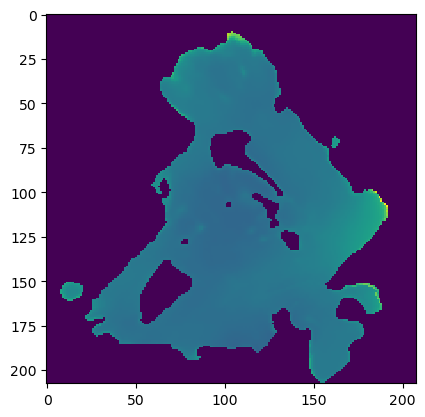

In [322]:
map = MAP_FILTER()
map.map_xy_size
plt.imshow(map.get_floor_2D_map())

In [323]:
map.map_z_size, 21*.04

(21, 0.84)

In [324]:
0.4/0.04

10.0

In [325]:
map.get_max_floor_height()*0.04, map.get_min_floor_height()*0.04

(0.6999999237060547, 0.29999996185302735)

In [326]:
obs_pc = map.obstacle_point_cloud()

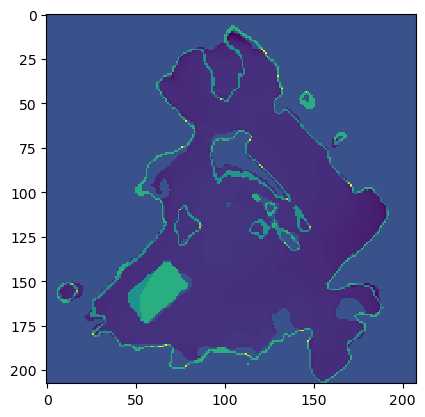

In [328]:

layer = obs_pc[:,:,8]
plt.imshow(layer*110 + map.get_floor_2D_map()*-5)
